In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from Games import *
import Utility
from os import listdir, mkdir
from os.path import join, isdir
from json import load
from glob import glob

In [3]:
FIGURE = 'figure'
if not isdir(FIGURE):
    mkdir(FIGURE)

In [4]:
PALETTE = {
    "Policy": "red", 
    "Q": "blue", 
    "Random": "green", 
    "Greedy": "purple"
}

# Mario Level Segments

In [5]:
def get_all_player_playthroughs(config, reward_str):
    playthroughs = []
    for path in glob(join(config.BASE_DIR, f'player*reward_{reward_str}.json')):
        path_split = path.split('/')[-1].split('_')
        player = path_split[1]
        director = path_split[-3]
        
        with open(path, 'r') as f:
            playthroughs.append((player, director, load(f)))

    return playthroughs

In [6]:
def get_df(playthroughs, order_column):
    data = []
    labels = ['Director', 'Player', 'Percent Complete', 'Player Reward', 'Design Reward','Both Reward']
    players = set()
    
    for player, director, run_data in playthroughs:
        players.add(player)
        for run in run_data:
            run_percent_complete = 0
            run_player_reward = 0
            run_design_reward = 0
            run_total_reward = 0

            for lvl in run:
                run_percent_complete += lvl['percent_complete']
                run_player_reward += lvl['percent_player_reward']
                run_design_reward += lvl['percent_design_reward']
                run_total_reward += lvl['percent_total_reward']
                    
            data.append((
                director, 
                player, 
                run_percent_complete / len(run), 
                run_player_reward / len(run), 
                run_design_reward / len(run), 
                run_total_reward / len(run)))
    
    df = pd.DataFrame(data, columns=labels) \
         .groupby(['Player', 'Director']) \
         .agg(['mean', 'std']) \
         .sort_values(by=['Player', (order_column, 'mean')], ascending=False)
    df = df.applymap("{0:.3f}".format)
    return df

In [7]:
config = Mario
graph = Utility.get_level_segment_graph(config, True)

rewards = ('Design Reward', 'Player Reward', 'Both Reward')

REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.DESIGNER)
designer_playthroughs = get_all_player_playthroughs(config, REWARD_STR)
df_designer = get_df(designer_playthroughs, rewards[0])

REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.PLAYER)
player_playthroughs = get_all_player_playthroughs(config, REWARD_STR)
df_player = get_df(player_playthroughs, rewards[1])

REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.BOTH)
both_playthroughs = get_all_player_playthroughs(config, REWARD_STR)
df_both = get_df(both_playthroughs, rewards[2])

Loading links from: ./GramElitesData/MarioData/gram_elites/links_True.json


In [57]:
def plot_player_personas_over_time(df_d, df_p, df_b, reward_names):
    data = {}
    
    for name, playthrough in zip(reward_names, (df_d, df_p, df_b)):
        data[name] = {}
        
        for player, alg, playthrough_data in player_playthroughs:
            if player not in data[name]:
                data[name][player] = []

            for session in playthrough_data:
                total_reward = 0
                for i, lvl in enumerate(session):
                    if name == reward_names[0]:
                        total_reward += lvl['percent_design_reward']
                    elif name == reward_names[1]:
                        total_reward += lvl['percent_player_reward']
                    elif name == reward_names[2]:
                        total_reward += lvl['percent_total_reward']
                    else:
                        raise KeyError(f'Unknown key: {name}.')
                        
                    data[name][player].append((alg, i, total_reward))

    # sort keys so the output is always in the same order
    player_names = list(data[reward_names[0]].keys())
    player_names.sort()
    
    # build plots and set title
    fig, axes = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(16,12))
    fig.suptitle(f'Title')
    
    # fill in each plot
    for y, name in enumerate(reward_names):
        for x, player in enumerate(player_names):
            plot_df = pd.DataFrame(data[name][player], columns=['alg', 'level', 'reward'])
            ax = sns.lineplot(ax=axes[y, x], data=plot_df, x='level', y='reward', hue='alg', palette=PALETTE)
            ax.get_legend().remove()
            ax.set_xlabel('')
            
            
            if y == 0:
                ax.set_title(player)
                
            if x == 0:
                ax.set_ylabel(name)
            else:
                ax.set_ylabel('')
                
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=2, bbox_to_anchor=(.905, 0.99))
    fig.text(0.5, 0.04, 'Level', ha='center', size=14)
#     fig.text(0.08, 0.5, 'Reward', va='center', rotation='vertical', size=14)
    plt.show()

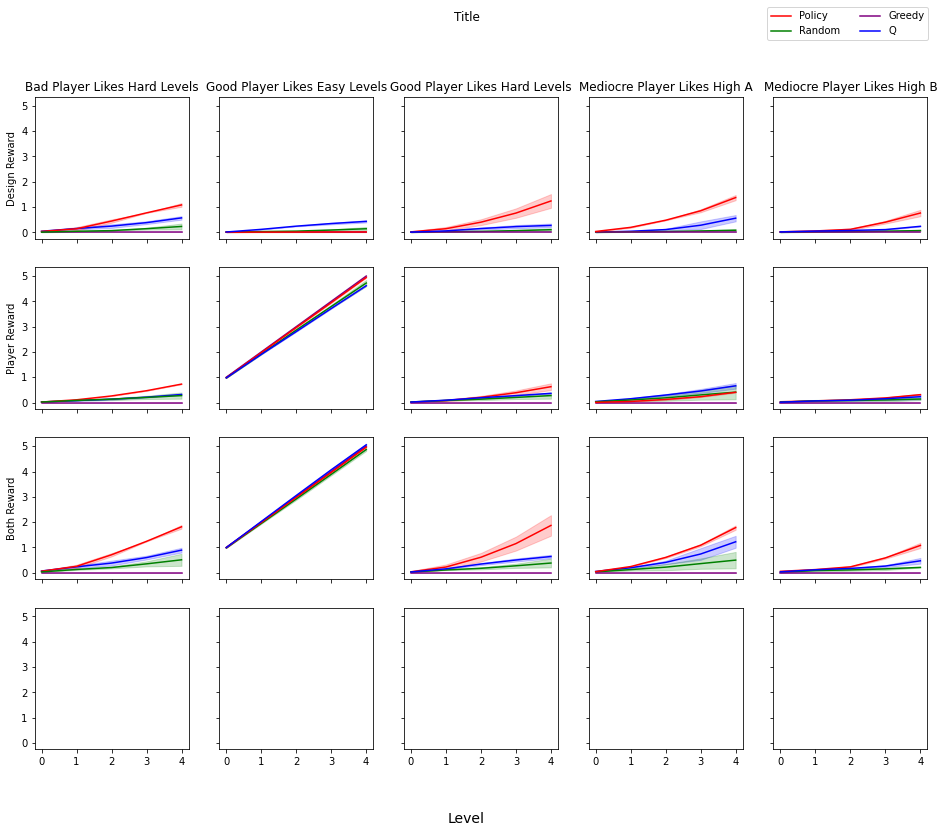

In [58]:
plot_player_personas_over_time(df_designer, df_player, df_both, rewards)